In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(os.getcwd())  # Print current working directory


/Users/snehitha/taxi_project/notebooks


In [3]:
import sys
import os

# Move up one level and add "src" directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

# Now import the module
import taxi_project.config as config


In [4]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-05 07:03:26,122 INFO: Initializing external client
2025-03-05 07:03:26,122 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 07:03:26,925 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215691


In [5]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1215691/featurestores/1203317/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [6]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.89s) 


In [7]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [8]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00+00:00,2,0
1,2023-01-01 01:00:00+00:00,2,0
2,2023-01-01 02:00:00+00:00,2,0
3,2023-01-01 03:00:00+00:00,2,0
4,2023-01-01 04:00:00+00:00,2,0


In [9]:
ts_data["pickup_hour"].min()

'2023-01-01 00:00:00+00:00'

In [10]:
ts_data["pickup_hour"].max()

'2025-03-05 02:00:00+00:00'

In [11]:
ts_data_copy = ts_data.copy()

In [12]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [13]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452296 entries, 0 to 2452295
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 37.4 MB


In [14]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [15]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452296 entries, 0 to 2452295
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 37.4 MB


In [16]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [17]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01
...,...,...,...,...
2452291,2025-03-04 22:00:00,263,58,2025-03
2452292,2025-03-04 23:00:00,263,30,2025-03
2452293,2025-03-05 00:00:00,263,22,2025-03
2452294,2025-03-05 01:00:00,263,10,2025-03


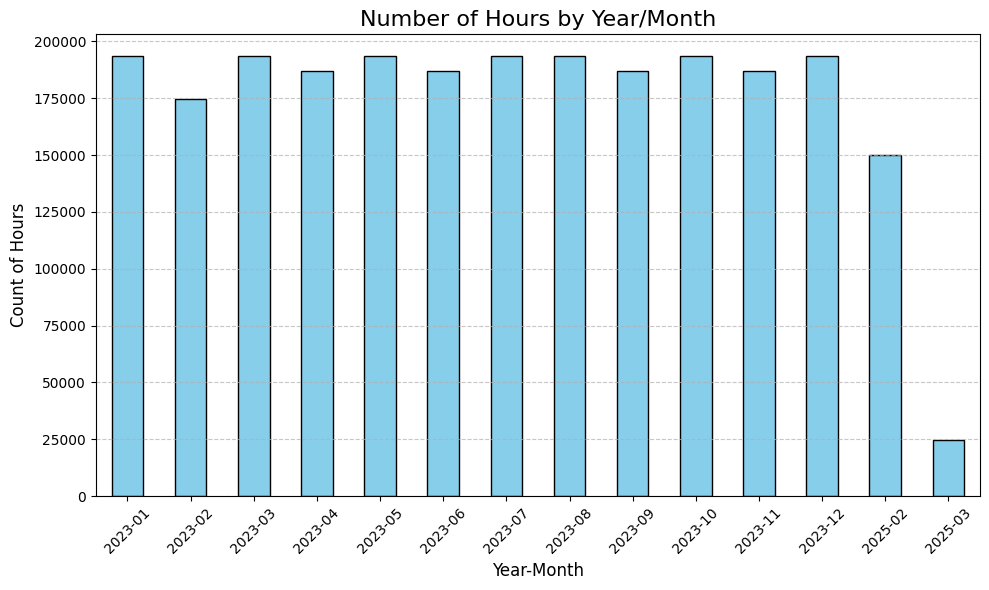

In [18]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [19]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [20]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [21]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [22]:
filtered_data.shape

(2277600, 3)

In [23]:
ts_data = filtered_data

In [24]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277600 entries, 0 to 2277599
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.8 MB


In [25]:
ts_data.head()["pickup_hour"].values

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', '2023-01-01T03:00:00.000000000',
       '2023-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [26]:
from taxi_project.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [27]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 13:00:00,263
91516,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 12:00:00,263
91517,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 11:00:00,263
91518,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 10:00:00,263


In [28]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-27 13:00:00,2
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-28 12:00:00,2
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-29 11:00:00,2
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-30 10:00:00,2


In [29]:
features_copy = features.copy()

In [30]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [31]:
from datetime import datetime, timedelta  
import pandas as pd  
from taxi_project.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-05 07:04:03.795009')

In [32]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(91520, 674)
(91520,)
(0, 674)
(0,)


In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91520 entries, 0 to 91519
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 470.3 MB


In [34]:
from taxi_project.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [35]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.259781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 91520, number of used features: 675
[LightGBM] [Info] Start training from score 16.630299


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x32157f6d0>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [36]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [37]:
predictions

array([ 0.16632143,  0.16632143,  0.16632143, ..., 83.42269769,
       75.76323756, 60.66289631])

In [38]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.9355


In [39]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/snehitha/taxi_project/src/models/lgb_model.pkl']

In [40]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [43]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('/Users/snehitha/taxi_project/src/models/lgb_model.pkl')

TypeError: create_model() got an unexpected keyword argument 'include_files'

In [82]:
import os
os.chdir("/Users/snehitha/taxi_project/")
print(f"Updated Working Directory: {os.getcwd()}")


Updated Working Directory: /Users/snehitha/taxi_project


In [83]:
import joblib
import os

# Define correct file path
model_path = os.path.join("C:\\Users\\snehitha\\TAXI_PROJECT\\models", "lgb_model.pkl")

# Print the model type before saving
print(f"✅ Model type before saving: {type(model)}")

# Ensure directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Extract actual model (Fixing Hopsworks storage issue)
if hasattr(model, "model"):  
    actual_model = model.model  # If 'model' has an internal model, extract it
else:
    actual_model = model  # Otherwise, assume 'model' is already correct

# Save model locally
joblib.dump(actual_model, model_path)

# Verify the file exists
if os.path.exists(model_path):
    print(f"✅ Model successfully saved at: {model_path}")
else:
    raise FileNotFoundError(f"❌ Model file not found at {model_path}")


 


✅ Model type before saving: <class 'hsml.sklearn.model.Model'>
✅ Model successfully saved at: C:\Users\snehitha\TAXI_PROJECT\models/lgb_model.pkl


In [84]:
model_path = "/Users/snehitha/taxi_project/src/models/lgb_model.pkl"


In [97]:
import os

model_path = "/Users/snehitha/taxi_project/src/models/lgb_model.pkl"

# Verify if the file actually exists
if os.path.exists(model_path):
    print(f"✅ Model file found at: {model_path}")
else:
    print(f"❌ Model file NOT found at: {model_path}")

# Attempt loading only if the file exists
import joblib
if os.path.exists(model_path):
    loaded_model = joblib.load(model_path)
    print(f"✅ Model successfully loaded: {type(loaded_model)}")
else:
    raise FileNotFoundError(f"Model file not found at: {model_path}")


✅ Model file found at: /Users/snehitha/taxi_project/src/models/lgb_model.pkl
✅ Model successfully loaded: <class 'sklearn.pipeline.Pipeline'>


In [98]:
import joblib

model_registry = project.get_model_registry()

# Ensure only the inner model is saved
if hasattr(model, "model"):  
    model_to_save = model.model  # Extract the actual sklearn model
else:
    model_to_save = model  # If not wrapped, use as is

print(f"✅ Model type before saving: {type(model_to_save)}")  # Ensure it's sklearn model
joblib.dump(model_to_save, "lgb_model.pkl")


# Register the model in Hopsworks Model Registry
registered_model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    description="LightGBM regressor",
    metrics={"test_mae": test_mae},
    input_example=features.sample(),
    model_schema=model_schema
)

# **Upload the saved model to the registry**
registered_model.save(model_path)
print("✅ Model successfully saved to registry")


✅ Model type before saving: <class 'hsml.sklearn.model.Model'>


Uploading: 100.000%|██████████| 317917/317917 elapsed<00:02 remaining<00:00  1.64it/s]
Uploading: 100.000%|██████████| 2048/2048 elapsed<00:01 remaining<00:000:06,  1.52s/it]
Uploading: 100.000%|██████████| 48705/48705 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215691/models/taxi_demand_predictor_next_hour/8
✅ Model successfully saved to registry


In [99]:
model = load_model_from_registry()
print(f"✅ Model loaded from registry: {type(model)}")

if hasattr(model, "model"):
    model = model.model  # Unwrap the actual model
    print(f"✅ Extracted inner model: {type(model)}")

if hasattr(model, "predict"):
    print("✅ Model has a predict method!")
else:
    print("❌ Model does NOT have a predict method!")


2025-03-05 08:00:37,716 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 08:00:37,723 INFO: Initializing external client
2025-03-05 08:00:37,723 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 08:00:38,356 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215691
Loading model from: /var/folders/1m/z5z5rmbs04j6lnjwzv65l1m80000gn/T/3f81274c-a056-4f88-9925-49b44900a0e1/taxi_demand_predictor_next_hour/8/lgb_model.pkl
Loaded object type: <class 'sklearn.pipeline.Pipeline'>
Loaded object is a valid model or pipeline.
✅ Model loaded from registry: <class 'sklearn.pipeline.Pipeline'>
✅ Model has a predict method!


In [96]:
print(f"✅ Model type before saving: {type(model_to_save)}")


✅ Model type before saving: <class 'hsml.sklearn.model.Model'>


In [100]:
from taxi_project.inference import load_model_from_registry

model = load_model_from_registry()
print(f"✅ Model loaded from registry: {type(model)}")

# Check if it has predict method
if hasattr(model, "predict"):
    print("✅ Model has a predict method!")
else:
    print("❌ Model does NOT have a predict method!")


2025-03-05 08:01:06,110 INFO: Closing external client and cleaning up certificates.


Connection closed.
2025-03-05 08:01:06,113 INFO: Initializing external client
2025-03-05 08:01:06,113 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 08:01:06,963 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215691
Loading model from: /var/folders/1m/z5z5rmbs04j6lnjwzv65l1m80000gn/T/de5bdc84-ef38-4f9c-8c97-10fb286d5f6f/taxi_demand_predictor_next_hour/8/lgb_model.pkl
Loaded object type: <class 'sklearn.pipeline.Pipeline'>
Loaded object is a valid model or pipeline.
✅ Model loaded from registry: <class 'sklearn.pipeline.Pipeline'>
✅ Model has a predict method!


In [101]:
model = load_model_from_registry()
print("Model loaded from registry type:", type(model))


2025-03-05 08:01:20,160 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 08:01:20,163 INFO: Initializing external client
2025-03-05 08:01:20,163 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 08:01:20,853 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215691
Loading model from: /var/folders/1m/z5z5rmbs04j6lnjwzv65l1m80000gn/T/7589f7b0-30d2-493e-a677-838d149d3126/taxi_demand_predictor_next_hour/8/lgb_model.pkl
Loaded object type: <class 'sklearn.pipeline.Pipeline'>
Loaded object is a valid model or pipeline.
Model loaded from registry type: <class 'sklearn.pipeline.Pipeline'>


In [102]:
from taxi_project.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-05 08:01:38,032 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 08:01:38,034 INFO: Initializing external client
2025-03-05 08:01:38,034 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 08:01:38,759 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215691
Loading model from: /var/folders/1m/z5z5rmbs04j6lnjwzv65l1m80000gn/T/43f5f9c7-2628-4101-a8bb-0c43ecb0e08f/taxi_demand_predictor_next_hour/8/lgb_model.pkl
Loaded object type: <class 'sklearn.pipeline.Pipeline'>
Loaded object is a valid model or pipeline.


In [103]:
from taxi_project.inference import get_model_predictions

In [104]:
preds = get_model_predictions(model, features_copy)

Model type: <class 'sklearn.pipeline.Pipeline'>


In [106]:
print(model.named_steps)


{'functiontransformer': FunctionTransformer(func=<function average_rides_last_4_weeks at 0x32157f6d0>), 'temporalfeatureengineer': TemporalFeatureEngineer(), 'lgbmregressor': LGBMRegressor()}


In [107]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
91515,263,86.0
91516,263,95.0
91517,263,83.0
91518,263,76.0


In [108]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8374
